In [1]:
import re
import json
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from pandarallel import pandarallel

# **DATASETS PREPROCESSING**

Before preprocessing, we have to define important functions and variables that we will use along this notebook.

In [2]:
pandarallel.initialize()
lemmatizer = WordNetLemmatizer()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# URL Regex to capture URL inside a text
url_regex = re.compile(
    r"(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.]"
    r"(?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|"
    r"int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|"
    r"ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|"
    r"be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|"
    r"cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|"
    r"dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|"
    r"gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|"
    r"hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|"
    r"ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|"
    r"lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|"
    r"mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|"
    r"pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|"
    r"rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|"
    r"su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|"
    r"tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|"
    r"yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)"
    r"[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)"
    r"|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?<!@)[a-z0-9]"
    r"+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|"
    r"biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|"
    r"travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|"
    r"ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|"
    r"bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|"
    r"dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|"
    r"fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|"
    r"hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|"
    r"ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|"
    r"lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|"
    r"mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|"
    r"pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|"
    r"sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|"
    r"tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|"
    r"us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@))"
)

In [4]:
# Helper functions for preprocessing

def add_urls(urls: pd.DataFrame, df: pd.DataFrame):
    """Add URLs from a DF to URL DF"""
    count = 0
    for index in df[~df['url'].isnull()].index:
        row = df.iloc[index]
        data = {'text': row['url'], 'label': row['label']}
        urls = pd.concat([urls, pd.DataFrame([data])], axis=0, ignore_index=True)
        count += 1
    df.drop(['url'], axis=1, inplace=True)
    return urls, count

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text: str):
    """Preprocess text with regex and NLTK library"""
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation signs and special chars
    text = re.sub(r' +', ' ', text) # remove unnecessary spaces
    text = text.lower() # put text in lower case
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)])
    return text.strip()

def split_dataset(df: pd.DataFrame, test_size: float, label: str):
    """Split dataset on training and test sets"""
    return train_test_split(df, test_size=test_size, stratify=df[label])

* * *

## **URLs DATASET**

In [5]:
# import urls dataset
urls = pd.read_csv('../DATASETS/INIT/URLS.csv')
# mapping 0 to 1 for phishing, and 1 to 0 for benign samples
urls['status'] = urls['status'].map({0: 1, 1: 0})
# renaming column to maintain uniformity
urls.rename(columns={'status': 'label', 'url': 'text'}, inplace=True)
# shuffling rows due to dataset structure
urls = urls.sample(frac=1).reset_index(drop=True)
urls

,text,label
0,http://216.127.171.242/,1
1,upcoming.yahoo.com/event/8545497/GA/Statesboro...,0
2,nhl.com/ice/page.htm?id=25429,0
3,lasell.edu/,0
4,http://www.acccaseoen.acacoccnsaa.qxykiz.top/,1
...,...,...
822005,answers.encyclopedia.com/question/la-francopho...,0
822006,www.tibiacommunit1y.za.pl/,1
822007,sane-productions.com,1
822008,www.epa.gov/opptintr/dfe/pubs/garment/gtcfact/...,0


#### Missing and Duplicated Values

In [6]:
print(f"There are missing values?: {urls.isna().any().any()}")
print(f"There are duplicated URLs?: {urls['text'].duplicated().any()}")
print(f"There are empty strings in url column?: {urls.where(urls['text'] == '').any().any()}")

There are missing values?: False
There are duplicated URLs?: True
There are empty strings in url column?: False


In [7]:
# Solving duplicates
urls = urls.drop_duplicates(subset=['text'])
urls.reset_index(drop=True, inplace=True)
print(f"URL dataset shape: {urls.shape}")

URL dataset shape: (808042, 2)


#### Balance Dataset

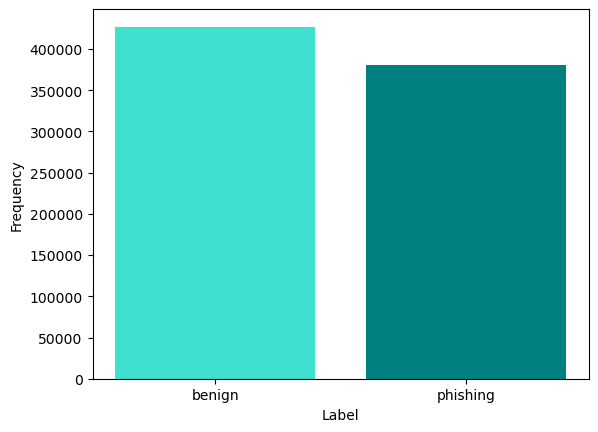

label
0    427028
1    381014
Name: count, dtype: int64


In [8]:
url_label_counts = urls['label'].value_counts()
plt.bar(['benign', 'phishing'], url_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(url_label_counts)

The dataset is balanced. This is also in accordance with the description of the dataset where it is mentioned: "52% of the domains are legitimate and the remaining 47% are phishing domains."

* * *

## **EMAILS DATASET**

In [9]:
# importing emails dataset
emails = pd.read_csv('../DATASETS/INIT/EMAILS.csv', index_col=0)
# renaming columns to maintain uniformity
emails.rename(columns={'Email Text': 'text', 'Email Type': 'label'}, inplace=True)
# mapping label values to 1 (phishing) and 0s (benign)
emails['label'] = emails['label'].map({'Phishing Email': 1, 'Safe Email': 0})
emails

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
...,...,...
18646,date a lonely housewife always wanted to date ...,1
18647,request submitted : access request for anita ....,0
18648,"re : important - prc mtg hi dorn & john , as y...",0
18649,press clippings - letter on californian utilit...,0


#### Missing and Duplicated Values

In [10]:
print(f"There are missing values?: {emails.isna().any().any()}")
print(f"There are duplicated emails?: {emails['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {emails.where(emails['text'] == '').any().any()}")

There are missing values?: True
There are duplicated emails?: True
There are empty strings in text column?: False


In [11]:
# Solving duplicated and missing values
emails = emails.drop_duplicates(subset=['text']) 
emails = emails.dropna(how='any',axis=0) 
emails = emails[emails['text'] != 'empty'] 
emails.reset_index(drop=True, inplace=True)
print(f"Emails dataset shape: {emails.shape}")

Emails dataset shape: (17536, 2)


#### Balance Dataset 

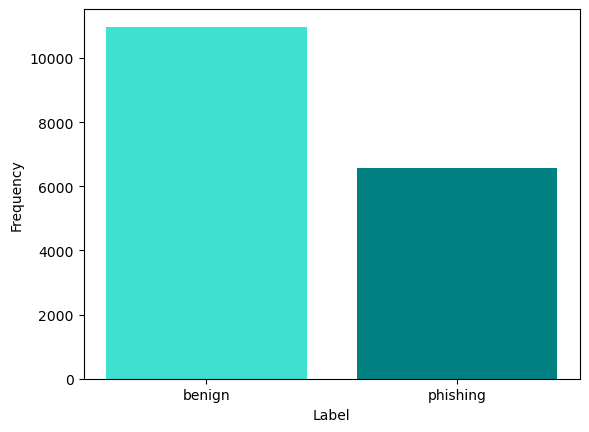

label
0    10979
1     6557
Name: count, dtype: int64


In [12]:
email_label_counts = emails['label'].value_counts()
plt.bar(['benign', 'phishing'], email_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(email_label_counts)

We have 10979 benign samples and 6557 phishing samples. That means that the proportions are: 
- 62.6% benign
- 37.4% phishing

There is no significant difference between classes proportion, so we can continue

#### URLs Extraction

Phishing emails usually have URLs inside the text. We can extract and add them to the URLs dataset to improve the training

In [13]:
# extract urls from emails text using regex
email_urls = []
for email in emails['text']:
    match = re.search(url_regex, email)
    if match:
        email_urls.append(match.group(0))
    else:
        email_urls.append(None)
emails['url'] = pd.Series(email_urls)

# adding urls from emails dataframe to URL dataframe
urls, urls_added_num = add_urls(urls, emails)

# print new urls added
print(f"New URLs added (+{urls_added_num}):\n")
urls

New URLs added (+4405):



,text,label
0,http://216.127.171.242/,1
1,upcoming.yahoo.com/event/8545497/GA/Statesboro...,0
2,nhl.com/ice/page.htm?id=25429,0
3,lasell.edu/,0
4,http://www.acccaseoen.acacoccnsaa.qxykiz.top/,1
...,...,...
812442,ArchiveIterator.pm,0
812443,NYTimes.com,0
812444,http://lists.freshrpms.net/mailman/listinfo/rp...,0
812445,http://diveintomark.org/archives/2002/09/25.ht...,0


#### Training and test set ✂️

In [14]:
train_emails, test_emails = split_dataset(emails, 0.2, 'label')

#### Preprocess Emails ✏️

Using NLTK and pandarallel we are going to preprocess emails train dataset for NLP tasks as quickly as possible.

In [15]:
train_emails['text'] = train_emails['text'].parallel_apply(preprocess_text)
train_emails

,text,label
8764,use handy interest calculator get current inte...,1
5978,cheap oem software shipping worldwide rhombus ...,1
12717,epe lending read whole thing follow e mail giv...,0
1120,new color printer sorry need know cost well fo...,0
13806,get software need save 40 popular software bun...,1
...,...,...
17105,liam bedford write cv version seem breakage co...,0
216,call generative linguistics first announcement...,0
11691,ready get hello viagra 1 med struggle men erec...,1
8136,mtv enlargement ripoffs join thousand satisfie...,1


* * *

## **SMS DATASET**

In [16]:
# import sms dataset
sms = pd.read_csv('../DATASETS/INIT/SMS.csv')
# rename, dropping and moving columns to maintain uniformity
sms.rename(columns={'LABEL': 'label', 'TEXT': 'text'}, inplace=True)
sms.drop(['EMAIL', 'PHONE', 'URL'], axis=1, inplace=True)
sms = sms.assign(label=sms.pop('label'))
# mapping label values to 1 (phishing) and 0s (benign)
sms['label'] = (sms['label'].str.lower()).map({'ham': 0, 'smishing': 1, 'spam': 1})
sms

,text,label
0,Your opinion about me? 1. Over 2. Jada 3. Kusr...,0
1,What's up? Do you want me to come online? If y...,0
2,So u workin overtime nigpun?,0
3,"Also sir, i sent you an email about how to log...",0
4,Please Stay At Home. To encourage the notion o...,1
...,...,...
5966,:( but your not here....,0
5967,Becoz its &lt;#&gt; jan whn al the post ofic...,0
5968,Its a valentine game. . . send dis msg to all ...,0
5969,We r outside already.,0


#### Missing and Duplicate Values

In [17]:
print(f"There are missing values?: {sms.isnull().any().any()}")
print(f"There are duplicated sms?: {sms['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {sms.where(sms['text'] == '').any().any()}")

There are missing values?: False
There are duplicated sms?: True
There are empty strings in text column?: False


In [18]:
# Solving duplicates
sms = sms.drop_duplicates(subset=['text'])
sms.reset_index(drop=True, inplace=True)
print(f"SMS dataset shape: {sms.shape}")

SMS dataset shape: (5949, 2)


#### Balance Dataset

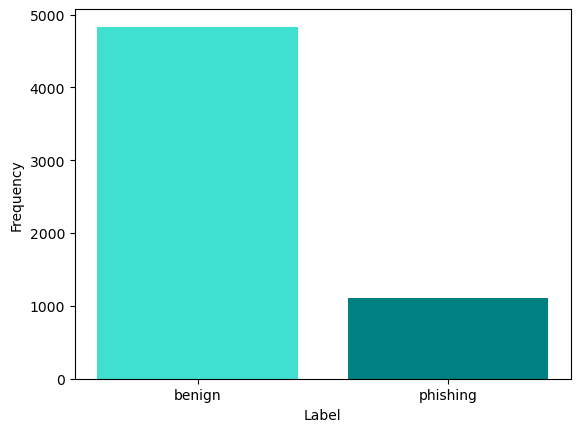

label
0    4834
1    1115
Name: count, dtype: int64


In [19]:
sms_label_counts = sms['label'].value_counts()
plt.bar(['benign', 'phishing'], sms_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(sms_label_counts)

We have an unbalanced dataset, with many more benign SMS messages than malicious ones. If we want to eliminate some benign samples in order to balance the dataset it we can use the **undersampling** method. This method consists in to reduce the number of observations of the majority class (in this case, the benign SMS) 
until it is equal to the number of observations of the minority class (in this case, the malignant SMS).

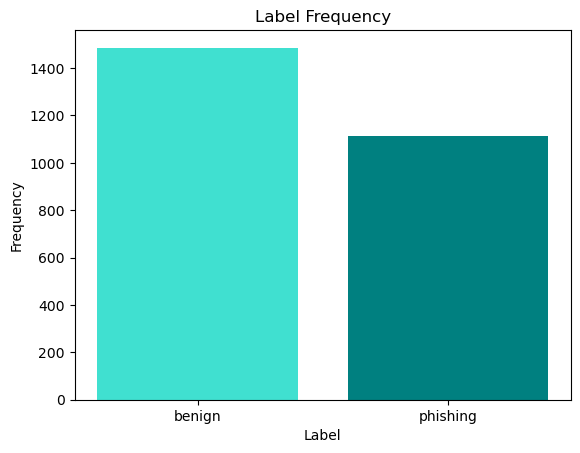

label
0    1486
1    1115
Name: count, dtype: int64


In [20]:
# calculate the size of the minority class
sms_minority_size = sms[sms['label'] == 1].shape[0]

# randomly select a subset of observations from the majority class
sms_majority_subset = sms[sms['label'] == 0].sample(
    n=sms_minority_size+(sms_minority_size//3),
    replace=False)

# combine the minority and majority subsets to create a new, balanced dataset
sms = pd.concat([sms_majority_subset, sms[sms['label'] == 1]])
sms.reset_index(drop=True, inplace=True)

sms_label_counts = sms['label'].value_counts()
plt.bar(['benign', 'phishing'], sms_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency')
plt.show()
print(sms_label_counts)

#### Extracción de URLs

In [21]:
# extract url from sms messages using regex
sms_urls = []
for message in sms['text']:
    match = re.search(url_regex, message)
    if match:
        sms_urls.append(match.group(0))
    else:
        sms_urls.append(None)
sms['url'] = pd.Series(sms_urls)

# add urls to URLs dataframe
urls, urls_added_num = add_urls(urls, sms)

# print new urls added
print(f"New URLs added (+{urls_added_num}):\n")
urls

New URLs added (+248):



,text,label
0,http://216.127.171.242/,1
1,upcoming.yahoo.com/event/8545497/GA/Statesboro...,0
2,nhl.com/ice/page.htm?id=25429,0
3,lasell.edu/,0
4,http://www.acccaseoen.acacoccnsaa.qxykiz.top/,1
...,...,...
812690,www.StockInNews.com,1
812691,www.phb1.com,1
812692,www.SMS.ac/u/natalie2k9,1
812693,uk.com,1


#### Split in training and test sets ✂️

In [22]:
train_sms, test_sms = split_dataset(sms, 0.2, 'label')

#### Preprocess SMS Messages ✏️

In [23]:
train_sms['text'] = train_sms['text'].parallel_apply(preprocess_text)
train_sms

,text,label
72,sweet heart,0
1967,girl bba mba executive mba b sc bio tech b tec...,1
1327,yup ok go home look timing msg ü xuhui go lear...,0
2049,hey really want chat see text 08718738034,1
310,think chennai well settle,0
...,...,...
255,depends quality want type sent boye fade glory...,0
1979,private 2003 account statement show 800 un red...,1
1146,ill obey,0
1377,aiyo u always c ex one dunno abt mei reply fir...,0


* * *

## **WEBSITES DATASET**

In [24]:
# we have to create a database to get html files
conn = sqlite3.connect(Path("~/Documents/WEBSITES/websites.db").expanduser())

# open and read index.sql, where html files are
with open(Path("~/Documents/WEBSITES/index.sql").expanduser(), "r") as f:
    sql = f.read()

sql = sql.replace("`", "'")
conn.executescript(sql)
conn.commit()

# read table data and pass it to a pandas dataframe
webs = pd.read_sql_query("SELECT * FROM \"index\" LIMIT 20000", conn)

conn.close()

webs.drop(['rec_id', 'created_date'], inplace=True, axis=1)
webs.rename(columns={'website': 'text', 'result': 'label'}, inplace=True)
webs

,url,text,label
0,http://intego3.info/EXEL/index.php,1613573972338075.html,1
1,https://www.mathopenref.com/segment.html,1635698138155948.html,0
2,https://www.computerhope.com/issues/ch000254.htm,1635699228889266.html,0
3,https://www.investopedia.com/terms/n/next-elev...,1635750062162701.html,0
4,https://jobs.emss.org.uk/lcc.aspx,161356510250721.html,0
...,...,...,...
19995,https://www.click.co.uk/bloggers-signup/,1635745139364882.html,0
19996,http://steamcoummunity.gq/en/chat/TaraKlass,1613572837296168.html,1
19997,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,1609107774284011.html,0
19998,https://hairfairly.com/docu/file/indexa.php,1613575453561959.html,1


#### HTML Codes Extraction

It's worthwhile to analyze the websites dataset. Nevertheless, processing each HTML code sample could be pretty heavy and delayed. That's why is necessary to filter those HTML samples that exceed a SIZE threshold. On this case, we decided the threshold to be: **100 KB**. Also, we can speed HTML extraction from disk by executing the code using Cython library. Cython compile python code in C, and this increases the performance significantly.

In [25]:
%load_ext Cython

In [26]:
%%cython
import os

MAX_FILE_SIZE = 100 # max file size in KB

prefix = os.path.expanduser("~/Documents/WEBSITES/DATASET/") # common prefix where HTML codes are stored
html_directories = [
    "dataset-part-1/", 
    "dataset-part-2/",
    "dataset-part-3/",
    "dataset-part-4/",
    "dataset-part-5/",
    "dataset-part-6/",
    "dataset-part-7/",
    "dataset-part-8/"]

def B_TO_KB(b):
    kilobytes = b / 1024
    return kilobytes

def get_html(filename):
    
    for directory in html_directories:
        dir_path = os.path.join(prefix, directory)
        files = os.listdir(dir_path)
        for file in files:
            if file == filename:
                html_path = os.path.join(dir_path, file)
                break
            
    if B_TO_KB(os.path.getsize(html_path)) <= MAX_FILE_SIZE:
        with open(html_path, 'r') as html_file:
            html = html_file.read()
        return html
    else:
        return None

In [27]:
# retrieve html codes from disk
webs['text'] = webs['text'].parallel_map(lambda file: get_html(file))
# drop those samples where html text is None, because they were too heavy
webs = webs[webs.text.notnull()]
# reset indexes after drop
webs.reset_index(drop=True, inplace=True)
# print resulting webs dataset shape
print(f"Webs dataset shape: {webs.shape}")
webs

Webs dataset shape: (13870, 3)


,url,text,label
0,http://intego3.info/EXEL/index.php,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",1
1,https://www.mathopenref.com/segment.html,<!DOCTYPE html>\n<html>\n <head>\n <title>\n ...,0
2,https://www.computerhope.com/issues/ch000254.htm,<!DOCTYPE html>\n<!--[if lt IE 7]><html class=...,0
3,https://jobs.emss.org.uk/lcc.aspx,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",0
4,http://www.pracspedia.com/INS/one-time-passwor...,<html>\n <head>\n <title>\n Not Acceptable!...,0
...,...,...,...
13865,https://543111.selcdn.ru/office/index8.html?em...,"<html class="""" dir=""ltr"" lang=""en"">\n <head>\n...",1
13866,https://www.stealthpay.com/,"<!DOCTYPE html>\n<html lang=""en-US"">\n <head>\...",0
13867,http://steamcoummunity.gq/en/chat/TaraKlass,<html>\n <head>\n <title>\n steamcoummunity...,1
13868,https://hairfairly.com/docu/file/indexa.php,"<!DOCTYPE html>\n<html dir=""ltr"" lang=""EN-US"">...",1


#### Missing and Duplicated Values

In [28]:
print(f"There are missing values?: {webs.isna().any().any()}")
print(f"There are duplicated webs: {webs['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {webs.where(webs['text'] == '').any().any()}")

There are missing values?: False
There are duplicated webs: True
There are empty strings in text column?: False


In [29]:
# Solving duplicates
webs = webs.drop_duplicates(subset=['text'])
webs.reset_index(drop=True, inplace=True)
print(f"Webs dataset shape: {webs.shape}")

Webs dataset shape: (10803, 3)


#### Balance Dataset

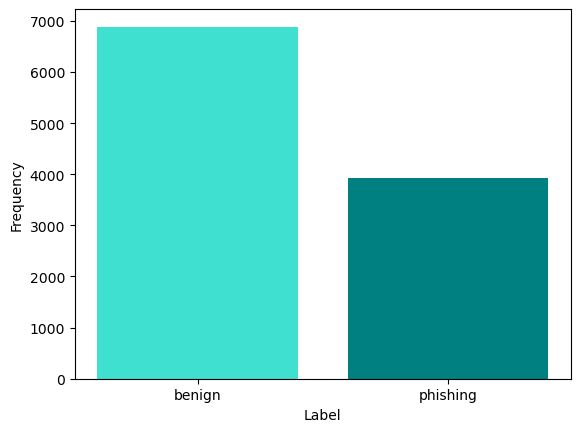

label
0    6886
1    3917
Name: count, dtype: int64


In [30]:
web_label_counts = webs['label'].value_counts()
plt.bar(['benign', 'phishing'], web_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(web_label_counts)

#### URLs Extraction

In [31]:
# add urls to URLs dataframe
urls, urls_added_num = add_urls(urls, webs)

# print new urls added
print(f"New URLs added (+{urls_added_num}):\n")
urls

New URLs added (+10803):



/var/folders/bf/74p6fnsx6v582xb04v67qg4r0000gn/T/ipykernel_17033/739879485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['url'], axis=1, inplace=True)


,text,label
0,http://216.127.171.242/,1
1,upcoming.yahoo.com/event/8545497/GA/Statesboro...,0
2,nhl.com/ice/page.htm?id=25429,0
3,lasell.edu/,0
4,http://www.acccaseoen.acacoccnsaa.qxykiz.top/,1
...,...,...
823493,https://vk-continuous.ru,1
823494,https://543111.selcdn.ru/office/index8.html?em...,1
823495,https://www.stealthpay.com/,0
823496,http://steamcoummunity.gq/en/chat/TaraKlass,1


In [32]:
webs.to_csv('../DATASETS/INIT/WEBS.csv', index=False)

#### Split in training and test sets ✂️

In [33]:
train_webs, test_webs = split_dataset(webs, 0.2, 'label')

#### Preprocess HTML texts ✏️

For preprocessing, we have to use, one more time, Cython library to speedup the iterations.

In [34]:
%%cython
import minify_html

def minify(html):
    return minify_html.minify(html)

In [35]:
# minifying html texts to improve training speed
train_webs['text'] = train_webs['text'].parallel_map(lambda html: minify(html))
train_webs

,text,label
7879,<title>\n ram.kossboss.com\n </title><style...,0
3723,"<!doctypehtml PUBLIC ""-//W3C//DTD XHTML 1.0 Tr...",1
2280,<html dir=ltr lang=en><title>\n Sign in to y...,1
7219,<!doctypehtml><html class=m2 lang=si><link rel...,1
7704,"<!doctypehtml PUBLIC ""-//W3C//DTD HTML 4.01 Tr...",1
...,...,...
2939,"<!doctypehtml><html prefix=""og: https://ogp.me...",0
6555,<!doctypehtml><html lang=en xml:lang=en xmlns=...,0
1279,"<html style=""user-select: none;""class=no-js la...",1
10653,"<!doctypehtml PUBLIC ""-//W3C//DTD XHTML 1.0 Tr...",0


Now that we've finished adding the new URLs, we can split the URLs dataset in training and test sets

In [36]:
train_urls, test_urls = split_dataset(urls, 0.2, 'label')

* * *

## **COMBINED DATASET**

Finally, we can combine all datasets we've preprocessed in a single dataset that stores: URLs, Emails, SMS and HTML codes. Great!

In [37]:
train_all = pd.concat([train_urls, train_emails, train_sms, train_webs], axis=0, ignore_index=True)
train_all = train_all.sample(frac=1).reset_index(drop=True)
train_all

,text,label
0,http://popupbarbados.com/wp-includes/certifica...,1
1,faux-lights.000webhostapp.com,1
2,yggui.de,1
3,http://awesometime4you.com/wp-admin/js/cmfr/54...,1
4,en.wikipedia.org/wiki/Michael_Richards,0
...,...,...
683543,cbssports.com/nfl/teams/roster/OAK/oakland-rai...,0
683544,www.convospark.com/wp-content//plugins/aio-sho...,1
683545,https://www3.idpas-nenklni.xyz/,1
683546,highbeam.com/doc/1G1-125227587.html,0


In [38]:
test_all = pd.concat([test_urls, test_emails, test_sms, test_webs], axis=0, ignore_index=True)
test_all = test_all.sample(frac=1).reset_index(drop=True)
test_all

,text,label
0,pipl.com/directory/name/Finestone/Daniel,0
1,tvnews.vanderbilt.edu/program.pl?ID=486553,0
2,[Tim]\n> One effect of getting rid of MINCOUNT...,0
3,performanceoutdooradvertising.com/folder/verif...,1
4,mikianvelope.ro/words/gdrive/login.php,1
...,...,...
170885,www.secured.paypal.com.cgi.bin.dspatch.autolog...,1
170886,thegagenweb.com/gamontgo/,0
170887,learnboost.github.com/cluster/,0
170888,secned.ugi.cc/database/login.htm,1


The resulting datasets we can export them as JSON files for further use in Hugging Face

In [39]:
def df_to_json(df: pd.DataFrame, filename: str):
    
    df_json = []
    for row in df.itertuples():
        df_json.append(
            {
                "text": row.text,
                "label": row.label
            }
        )
    with open(f"DATASETS/END/{filename}.json", "w", encoding='utf-8') as f:
        json.dump(df_json, f, indent=2)

In [40]:
df_to_json(train_all, 'train')
df_to_json(test_all, 'test')

* * *

## **EXPERIMENTS**

For further experiments, we're going to save preprocessed and test datasets in CSV files

In [41]:
train_urls.to_csv('../DATASETS/EXP/TRAIN_URLS.csv', index=False)
train_emails.to_csv('../DATASETS/EXP/TRAIN_EMAILS.CSV', index=False)
train_sms.to_csv('../DATASETS/EXP/TRAIN_SMS.CSV', index=False)
train_webs.to_csv('../DATASETS/EXP/TRAIN_WEBS.csv', index=False)
test_emails.to_csv('../DATASETS/EXP/TEST_EMAILS.CSV', index=False)
test_sms.to_csv('../DATASETS/EXP/TEST_SMS.CSV', index=False)
test_webs.to_csv('../DATASETS/EXP/TEST_WEBS.csv', index=False)
test_urls.to_csv('../DATASETS/EXP/TEST_URLS.csv', index=False)